In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
df = pd.read_csv('./processedData.csv')

# Convert the 'Full date' to datetime format
df['Full date'] = pd.to_datetime(df['Full date'])

# Extract features: Year, Month, Day, Rain
df['Day'] = df['Full date'].dt.day
df['Year'] = df['Full date'].dt.year
df['Month'] = df['Full date'].dt.month

# Select features and target
features = ['Year', 'Month', 'Day']
target = ['Temp Max', 'Temp Min']

# Normalize the features and targets
scaler = MinMaxScaler()
df[features + target] = scaler.fit_transform(df[features + target])

# Prepare the data for LSTM
sequence_length = 50  # Number of days to look back
X, y = [], []
for i in range(sequence_length, len(df)):
    X.append(df[features].iloc[i-sequence_length:i].values)
    y.append(df[target].iloc[i].values)
X, y = np.array(X), np.array(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [17]:


# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step output
        return out

# Initialize the model, loss function, and optimizer
model = LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/15], Loss: 0.0052
Epoch [2/15], Loss: 0.0083
Epoch [3/15], Loss: 0.0082
Epoch [4/15], Loss: 0.0061
Epoch [5/15], Loss: 0.0050
Epoch [6/15], Loss: 0.0046
Epoch [7/15], Loss: 0.0066
Epoch [8/15], Loss: 0.0039
Epoch [9/15], Loss: 0.0050
Epoch [10/15], Loss: 0.0055
Epoch [11/15], Loss: 0.0052
Epoch [12/15], Loss: 0.0047
Epoch [13/15], Loss: 0.0095
Epoch [14/15], Loss: 0.0025
Epoch [15/15], Loss: 0.0050


Shape of test_predictions: (4300, 2)
Shape of predictions after inverse transform: (4300, 2)
Shape of y_test_original: (4300, 2)
Manual R² Score for Max Temperature: 0.7632466360239278


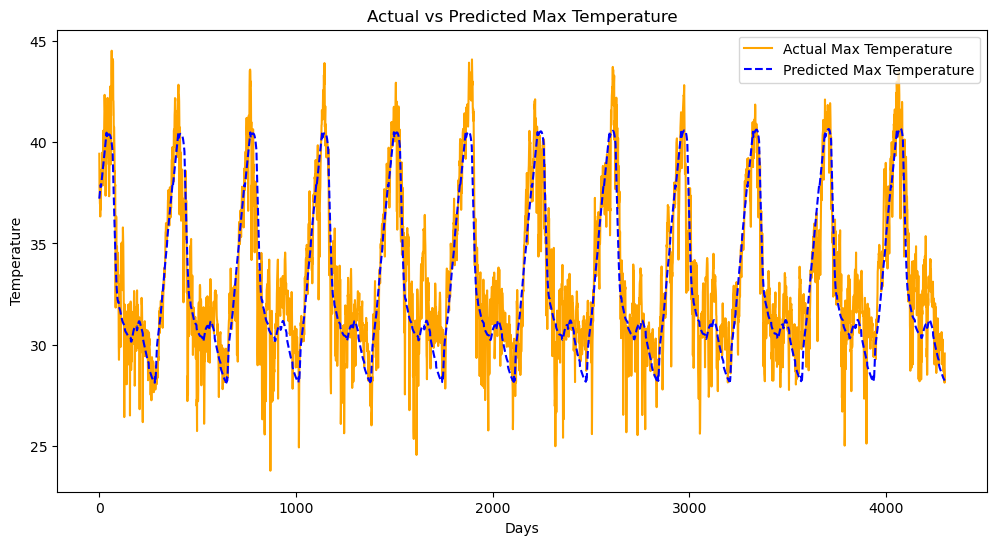

In [18]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Get predictions
    test_predictions = model(X_test_tensor)

# Convert to NumPy array
test_predictions = test_predictions.numpy()

# Check the shape of test_predictions
print("Shape of test_predictions:", test_predictions.shape)

# Ensure it's of shape (num_samples, num_features)
if test_predictions.ndim == 1:
    test_predictions = test_predictions.reshape(-1, 2)  # Reshape if it's one-dimensional

# Create an array for inverse transformation with the same number of features as the scaler
# Here we create a dummy array for the other features (Year, Month, Day) since we only need to inverse-transform Temp Max and Temp Min
# Use the original features' means (or some constant values) to fill the first three columns
dummy_features = np.zeros((test_predictions.shape[0], 3))  # Shape (num_samples, 3)
predictions = scaler.inverse_transform(np.hstack((dummy_features, test_predictions)))[:, 3:5]

# Reshape y_test for inverse transformation
y_test_original = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 3)), y_test)))[:, 3:5]  # Transforming only the relevant columns

# Check the shapes of the predictions and original targets
print("Shape of predictions after inverse transform:", predictions.shape)
print("Shape of y_test_original:", y_test_original.shape)

# Calculate R² Score
def calculate_r2(y_true, y_pred):
    ss_total = ((y_true - np.mean(y_true)) ** 2).sum()
    ss_residual = ((y_true - y_pred) ** 2).sum()
    r2_score = 1 - (ss_residual / ss_total)
    return r2_score

# Calculate R² Score only for the relevant target variable
r2_max = calculate_r2(y_test_original[:, 0], predictions[:, 0])  # Temp Max
print(f'Manual R² Score for Max Temperature: {r2_max}')

# Optional: Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_original[:, 0], label='Actual Max Temperature', color='orange')
plt.plot(predictions[:, 0], label='Predicted Max Temperature', color='blue', linestyle='--')
plt.title('Actual vs Predicted Max Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature')
plt.legend()
plt.show()
